In [1]:
%reset -s -f

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({'font.size':24})
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams.update({'font.weight':'bold'})
plt.rcParams["font.family"] = "Times New Roman"
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

#### Function for LLGS Equation

In [4]:
def LLGS(m,Heff,beta_STT,beta_SOT,alpha,H_STT,H_SOT):
    global mu0, gamma
    
    precission=-gamma*np.cross(m,Heff)
    damping=-alpha*gamma*np.cross(m,np.cross(m,Heff))
    Field_like_STT=gamma*(alpha-beta_STT)*(np.cross(m,H_STT))
    Damp_like_STT=-gamma*((alpha*beta_STT)+1)*np.cross(m,np.cross(m,H_STT))
    Field_like_SOT=gamma*(alpha-beta_SOT)*np.cross(m,H_SOT)
    Damp_like_SOT=-gamma*((alpha*beta_SOT)+1)*np.cross(m,np.cross(m,H_SOT))
    
    total_torque=precission+damping+Field_like_STT+Damp_like_STT+Field_like_SOT+Damp_like_SOT
    
    dmdt=(mu0/(1+alpha**2))*total_torque
    
    return dmdt

#### Function for Effective field calculation

In [5]:
def H_eff_calc(m,Han,Nx,Ny,Nz,Hext):
    H_uni=Han*m[2]*np.array([0,0,1])                           # in A/m
    H_demag=-(Ms/mu0)*np.array([Nx*m[0], Ny*m[1], Nz*m[2]])    # in A/m
        
    H_eff=H_uni+H_demag+H_ext
    
    return H_eff

In [6]:
def vec_mag(A):
    return np.sqrt((A*A).sum())

#### Function for calculating the cos$\theta$, where $\theta$ is the angle between PL and FL

In [7]:
def cos_theta(m):
    global PL_vec
    return np.dot(m,PL_vec)/(vec_mag(m)*vec_mag(PL_vec))

#### Function to calculate $\eta$

In [8]:
def eta(m):
    global P    
    return P/(1+(P**2)*cos_theta(m))

#### Function to calculate resistance of the MTJ

In [9]:
def R_MTJ(m,V_MTJ):
    global Rp, Rap, Vh    
    R=Rp+((Rap-Rp)*(1-cos_theta(m))/(2*(1+V_MTJ/Vh)**2))
    return R

#### Function to calculate |$\overrightarrow{H}_{STT}$|

In [10]:
def H_STT_mag(m,V_MTJ):
    global hbar, t_FL, Ms
    I_STT=V_MTJ/R_MTJ(m,V_MTJ)
    J_STT=I_STT/A_MTJ
    mag=(eta(m)*hbar*J_STT)/(2*q*t_FL*Ms)
    
    return mag

#### Function to calculate |$\overrightarrow{H}_{SOT}$|

In [11]:
def H_SOT_mag(V_HM):
    global hbar, t_FL, Ms, R_HM, A_HM, t_HM, lambda_sf, theta_SH
    I_c_HM=V_HM/R_HM
    J_c_HM=I_c_HM/A_HM
    J_SOT_mag=theta_SH*J_c_HM*(1-(1/np.cosh(t_HM/lambda_sf)))
    Hsotmag=(hbar*J_SOT_mag)/(2*q*t_FL*Ms)
    
    return Hsotmag    

#### Universal Constants

In [12]:
gamma=1.76e11;           # in [(rad)/(s.T)]
mu0=4*np.pi*1e-7 ;       # in T.m/A
q=1.6e-19;               # in Coulomb
hbar=1.054e-34;          # in (J-s)
K_B=1.38064852e-23       #in J/K

#### Parameters

In [13]:
A_MTJ=50*90*1e-18      # in m^2
t_FL=3e-9              # in nm
RA=1.5*(1e-6)**2       # in Ohm-m^2
Ku_Bulk=2.245e5        # in J/m^3
Ki=1.286e-3            # in J/m^3
Ms=1.58                # in T
L_HM=100e-9            # in m
W_HM=100e-9            # in m
t_HM=5e-9              # in m
rho_HM=200e-8          # in Ohm-m
lambda_sf=5e-9         # in m
theta_SH=-0.1           # dimensionless
P=0.4                  # dimensionless
TMR=150                # in %
alpha=0.025            # dimensionless
Vh=0.5
PL_vec=np.array([0,-1,0])
Ny=0.03984407224293963 # dimensionless
Nx=0.07340636630038447 # dimensionless
Nz=0.8867495614566816  # dimensionless

#### Calculated parameters

In [14]:
Rp=RA/A_MTJ                             # in Ohm
Rap=((TMR/100.0)+1)*Rp                  # in Ohm

Han=(2*(Ku_Bulk+(Ki/t_FL)))/(Ms)        # in A/m

A_HM=W_HM*t_HM
R_HM=rho_HM*L_HM/A_HM

In [15]:
R_HM

400.0

#### Assumed Parameters

In [16]:
VDD_SOT=6*0.27                             # in V
VDD_STT=6*0.27                              # in V

V_MTJ=VDD_STT

In [17]:
I_C_SOT=VDD_SOT/R_HM
I_C_SOT

0.004050000000000001

#### External Magnetic field

In [18]:
H_ext_mag=1.2*529*1e3/(4*np.pi)                                 # in A/m
H_ext=H_ext_mag*np.array([0,1,0])

In [19]:
beta_STT=0.8
beta_SOT=2.9

In [20]:
t_start=0
t_step=1e-12
t_end=20e-9
N=int(t_end/t_step)+1
t_save=np.zeros(N)
t_save[0]=t_start

In [21]:
mx=0.05
m_init=np.array([mx, -np.sqrt(1-mx**2), 0])

m_save=np.zeros((N,3))
m_save[0,:]=m_init

In [22]:
h=t_step
t=t_start
i=0
m=m_init
while t<t_end:
    t=t+t_step
    #print('-------------------------------------')
    #print('Time = ' + str(t*1e9)+' ns')
    t_save[i+1]=t
    
    Heff=H_eff_calc(m,Han,Nx,Ny,Nz,H_ext)
    H_STT=H_STT_mag(m,VDD_STT)*PL_vec
    H_SOT=H_SOT_mag(VDD_SOT)*np.array([0,-1,0])
    
    k1=LLGS(m,Heff,beta_STT,beta_SOT,alpha,H_STT,H_SOT)
    mk2=m+h*k1/2.0
    Heff=H_eff_calc(mk2,Han,Nx,Ny,Nz,H_ext)
    H_STT=H_STT_mag(mk2,VDD_STT)*PL_vec
    H_SOT=H_SOT_mag(VDD_SOT)*np.array([0,-1,0])
    
    k2=LLGS(mk2,Heff,beta_STT,beta_SOT,alpha,H_STT,H_SOT)
    mk3=m+h*k2/2.0
    Heff=H_eff_calc(mk3,Han,Nx,Ny,Nz,H_ext)
    H_STT=H_STT_mag(mk3,VDD_STT)*PL_vec
    H_SOT=H_SOT_mag(VDD_SOT)*np.array([0,-1,0])
    
    k3=LLGS(mk3,Heff,beta_STT,beta_SOT,alpha,H_STT,H_SOT)
    mk4=m+h*k3
    Heff=H_eff_calc(mk4,Han,Nx,Ny,Nz,H_ext)
    H_STT=H_STT_mag(mk4,VDD_STT)*PL_vec
    H_SOT=H_SOT_mag(VDD_SOT)*np.array([0,-1,0])
    
    k4=LLGS(mk4,Heff,beta_STT,beta_SOT,alpha,H_STT,H_SOT)
    
    m_new=m + ((h/6.0)*(k1+2*k2+2*k3+k4))
    m=m_new
    '''
    H_demag=-(Ms/mu0)*np.array([Nx*m[0], Ny*m[1], Nz*m[2]]) 
    H_STT=H_STT_mag(m,VDD_STT)*PL_vec
    H_SOT=H_SOT_mag(VDD_SOT)*np.array([0,-1,0])
    H_uni=Han*m[2]*np.array([0, 0, 1])
    print('H_uni = ' + str(H_uni))
    print('H_Demag = ' + str(H_demag))
    print('H_ext = ' + str(H_ext))
    print('H_SOT = ' + str(H_SOT))
    print('H_STT = ' + str(H_STT))
    
    
    '''
    
    i=i+1
    
    
    m_save[i,:]=m_new
    
    

    

In [23]:
t_save=t_save*1e9

In [24]:
t

2.000000000000294e-08

In [25]:
t_end

2e-08

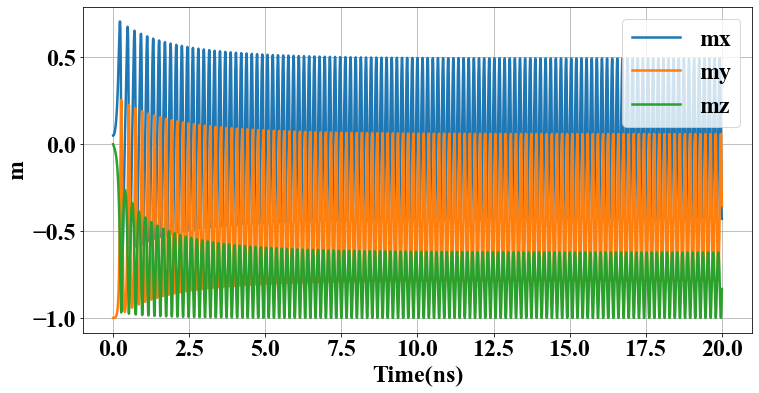

In [26]:
plt.figure(figsize=(12,6))
plt.plot(t_save,m_save[:,0], linewidth=2.5, label='mx')
plt.plot(t_save,m_save[:,1], linewidth=2.5, label='my')
plt.plot(t_save,m_save[:,2], linewidth=2.5, label='mz')
plt.legend()
plt.xlabel('Time(ns)')
plt.ylabel('m')
plt.grid()

In [27]:
np.sqrt((m*m).sum())

0.9999998565192543

In [28]:
np.shape(t_save)

(20001,)

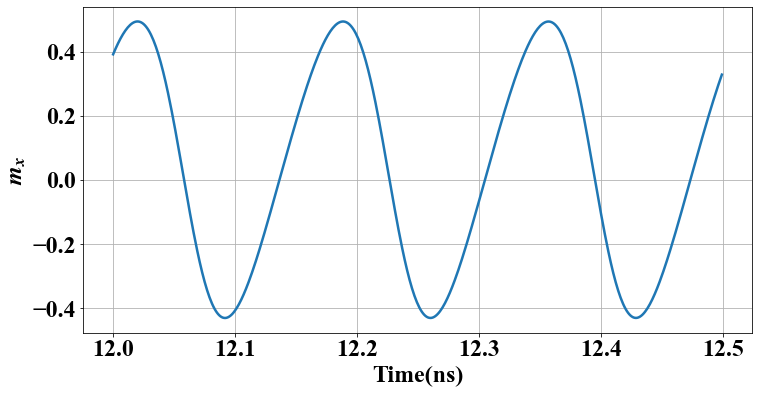

In [29]:
plt.figure(figsize=(12,6))
plt.plot(t_save[12000:12500],m_save[12000:12500,0], linewidth=2.5)
plt.xlabel('Time(ns)')
plt.ylabel(r"$m_x$")
plt.grid()

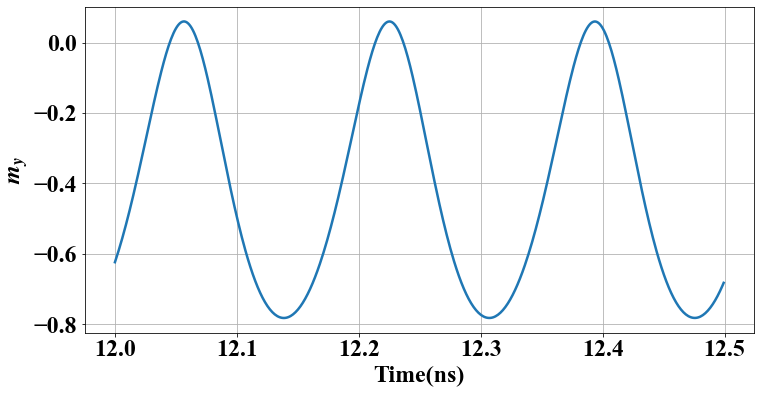

In [30]:
plt.figure(figsize=(12,6))
plt.plot(t_save[12000:12500],m_save[12000:12500,1], linewidth=2.5)
plt.xlabel('Time(ns)')
plt.ylabel(r"$m_y$")
plt.grid()

In [31]:
from mpl_toolkits import mplot3d
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [32]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [33]:
r = 1
phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]

x = r*np.sin(phi)*np.cos(theta)
y = r*np.sin(phi)*np.sin(theta)
z = r*np.cos(phi)

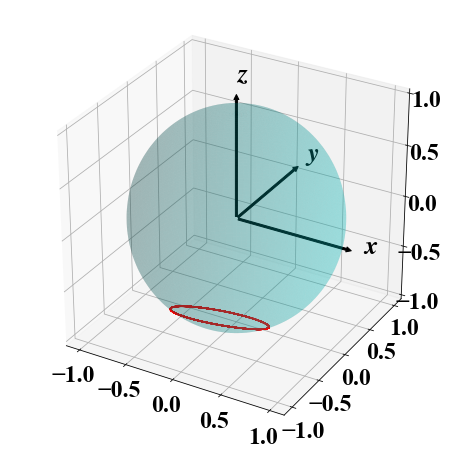

In [34]:
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection ='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.2, linewidth=2.0)
ax.plot3D(m_save[12000:14000,0], m_save[12000:14000,1], m_save[12000:14000,2], 'red')

ax.arrow3D(0,0,0,
           0,0,1.2*r,
           mutation_scale=10,
           ec ='black',
           fc='black')
ax.text(0,0,1.3*r, r"$z$", size=26, zorder=1,  color='k')
ax.arrow3D(0,0,0,
           0,1.2*r,0,
           mutation_scale=10,
           ec ='black',
           fc='black')
ax.text(0,1.3*r,0, r"$y$", size=26, zorder=1,  color='k')
#ax.text(0,-2.2*r,0, r"$m_\mathrm{x}$", size=36, zorder=1,  color='k')
ax.arrow3D(0,0,0,
           1.2*r,0,0,
           mutation_scale=10,
           ec ='black',
           fc='black')
ax.text(1.3*r,0,0, r"$x$", size=26, zorder=1,  color='k')

#ax.set_title('3D line plot geeks for geeks')
plt.show()